<a href="https://colab.research.google.com/github/firdowsacige/brain_tumor/blob/main/Deeplabv3%2B_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:

# Mount Google Drive (Optional, if saving models)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
pip install tensorflow

In [103]:
!pip install opencv-python-headless


In [104]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout,Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D


SEED = 65
IMG_SIZE = 224,224
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

In [105]:
!pip install wget
import wget
import zipfile

In [106]:
url = "http://datasets.simula.no/downloads/kvasir-seg.zip"
zip_path = "kvasir-seg.zip"
wget.download(url, zip_path)

'kvasir-seg (3).zip'

In [107]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/kvasir_seg")

In [108]:
!pip install torchinfo


In [109]:
import os
import pandas as pd
from sklearn.utils import shuffle

# Your directories
image_dir = "/content/kvasir_seg/Kvasir-SEG/images"
mask_dir = "/content/kvasir_seg/Kvasir-SEG/masks"

# List image and mask files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Make full paths
images = [os.path.join(image_dir, img) for img in image_files]
masks = [os.path.join(mask_dir, msk) for msk in mask_files]

# Create DataFrame
full_data = pd.DataFrame({'image': images, 'mask': masks})

# Shuffle the data
full_data = shuffle(full_data).reset_index(drop=True)

# Show a few rows
display(full_data.head())


image  \
0  /content/kvasir_seg/Kvasir-SEG/images/cju85je7...   
1  /content/kvasir_seg/Kvasir-SEG/images/cju5u6wf...   
2  /content/kvasir_seg/Kvasir-SEG/images/cju33x0f...   
3  /content/kvasir_seg/Kvasir-SEG/images/cju6vucx...   
4  /content/kvasir_seg/Kvasir-SEG/images/cju2hdr0...   

                                                mask  
0  /content/kvasir_seg/Kvasir-SEG/masks/cju85je7v...  
1  /content/kvasir_seg/Kvasir-SEG/masks/cju5u6wf0...  
2  /content/kvasir_seg/Kvasir-SEG/masks/cju33x0f2...  
3  /content/kvasir_seg/Kvasir-SEG/masks/cju6vucxv...  
4  /content/kvasir_seg/Kvasir-SEG/masks/cju2hdr06...

In [110]:

SEED = 65
X_train, X_test, y_train, y_test = train_test_split(
    full_data['image'], full_data['mask'], test_size=0.2, random_state=SEED
)


print("X_train shape -> ", X_train.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (800,)
X_test shape ->  (200,)


In [111]:
# Reading and resizing images and masks

def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask

In [112]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_train.shape[0])
                 .prefetch(AUTO))





test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [113]:
# Convolutional block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias

        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.norm = BatchNormalization()
        self.act = Activation(activation)

    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }

In [114]:
# DilatedSpatialPyramidPooling class for DeepLabv3+ model

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4

        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)


    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)

        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [115]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, AveragePooling2D, Conv2D, UpSampling2D, Concatenate

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4):
        super().__init__()
        self.avg_pool = AveragePooling2D(pool_size=(2, 2))  # use smaller pool if needed
        self.upsample = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.convout1 = Conv2D(256, kernel_1, dilation_rate=dil1, padding='same')
        self.convout2 = Conv2D(256, kernel_2, dilation_rate=dil2, padding='same')
        self.convout3 = Conv2D(256, kernel_3, dilation_rate=dil3, padding='same')
        self.convout4 = Conv2D(256, kernel_4, dilation_rate=dil4, padding='same')
        self.outconv = Conv2D(256, 1, padding='same')

    def call(self, inputs):
        input_shape = tf.shape(inputs)[1:3]  # get spatial size dynamically (e.g., 14x14)

        X_p = self.avg_pool(inputs)
        X_p = self.upsample(X_p)  # bring to input spatial size (14x14)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)

        # Make sure all shapes are the same before concatenation
        X_p = tf.image.resize(X_p, input_shape, method='bilinear')

        C = Concatenate(axis=-1)([X_p, X_1, X_2, X_3, X_4])
        X = self.outconv(C)
        return X



    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}


In [116]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

In [117]:
# Custom callback for predicting one sample from test dataset during training each epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):

        if (epochs + 1) % 1 == 0:
            samples = list(test_dataset.take(-1))

            idxs = np.random.permutation(X_test.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs

            image = samples[batch_idx][0][image_idx]
            mask = samples[batch_idx][1][image_idx]

            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.3
            bitmap_pred = (pred_ > threshold).astype(np.uint8)

            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)

            plt.tight_layout()
            plt.show()
        else:
            pass


In [118]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
dsp_block = DilatedSpatialPyramidPooling(kernel_1=1, kernel_2=3, kernel_3=3, kernel_4=3,
                                         dil1=1, dil2=6, dil3=12, dil4=18)
X = dsp_block(X)


X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard])
my_callbacks = [PredictDuringTraining()]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 11,779,457 (44.94 MB)

 Trainable params: 11,750,913 (44.83 MB)

 Non-trainable params: 28,544 (111.50 KB)

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.3647 - dice_coef_loss: 0.6353 - jaccard: 0.2350 - loss: 0.5827

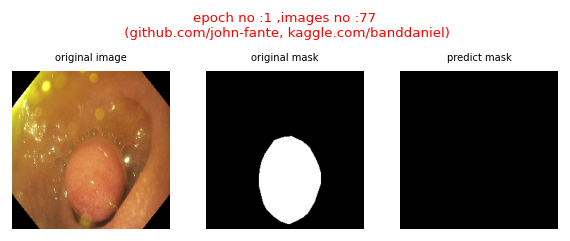

100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 76ms/step - dice_coef: 0.3657 - dice_coef_loss: 0.6343 - jaccard: 0.2358 - loss: 0.5803
Epoch 2/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.6235 - dice_coef_loss: 0.3765 - jaccard: 0.4568 - loss: 0.2122

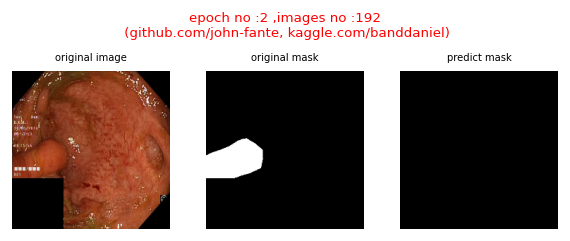

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.6238 - dice_coef_loss: 0.3762 - jaccard: 0.4571 - loss: 0.2120
Epoch 3/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.6951 - dice_coef_loss: 0.3049 - jaccard: 0.5360 - loss: 0.1634

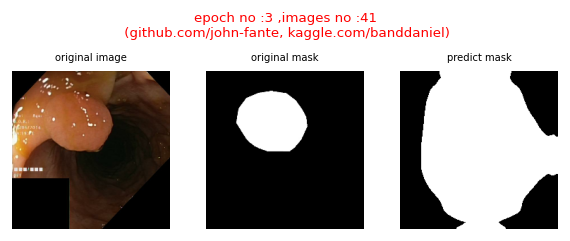

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.6950 - dice_coef_loss: 0.3050 - jaccard: 0.5360 - loss: 0.1634
Epoch 4/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.7248 - dice_coef_loss: 0.2752 - jaccard: 0.5734 - loss: 0.1429

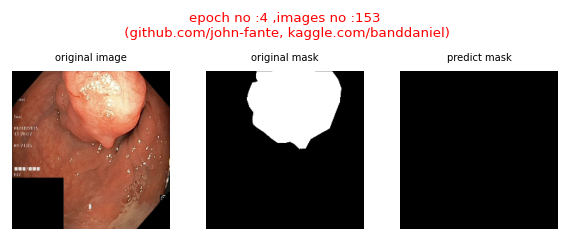

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.7249 - dice_coef_loss: 0.2751 - jaccard: 0.5735 - loss: 0.1429
Epoch 5/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.7728 - dice_coef_loss: 0.2272 - jaccard: 0.6339 - loss: 0.1208

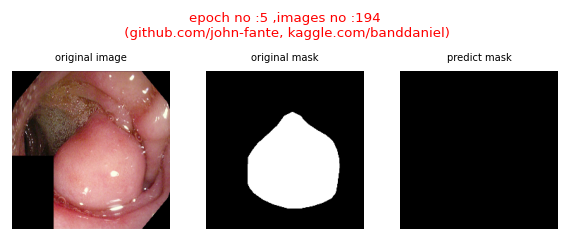

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.7729 - dice_coef_loss: 0.2271 - jaccard: 0.6340 - loss: 0.1207
Epoch 6/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8282 - dice_coef_loss: 0.1718 - jaccard: 0.7100 - loss: 0.0921

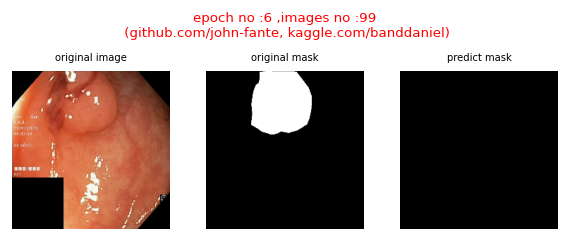

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.8280 - dice_coef_loss: 0.1720 - jaccard: 0.7098 - loss: 0.0922
Epoch 7/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.8529 - dice_coef_loss: 0.1471 - jaccard: 0.7462 - loss: 0.0747

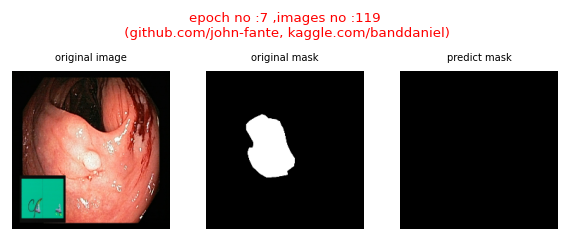

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.8528 - dice_coef_loss: 0.1472 - jaccard: 0.7460 - loss: 0.0748
Epoch 8/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8772 - dice_coef_loss: 0.1228 - jaccard: 0.7829 - loss: 0.0632

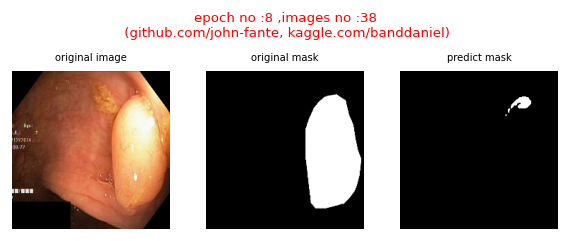

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.8774 - dice_coef_loss: 0.1226 - jaccard: 0.7832 - loss: 0.0631
Epoch 9/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9132 - dice_coef_loss: 0.0868 - jaccard: 0.8412 - loss: 0.0442

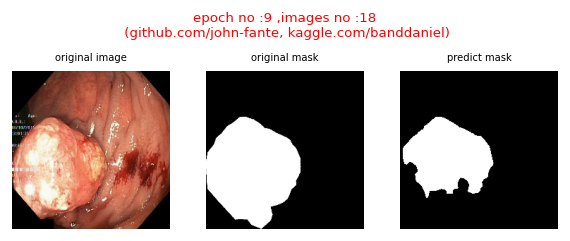

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9133 - dice_coef_loss: 0.0867 - jaccard: 0.8413 - loss: 0.0442
Epoch 10/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9214 - dice_coef_loss: 0.0786 - jaccard: 0.8552 - loss: 0.0427

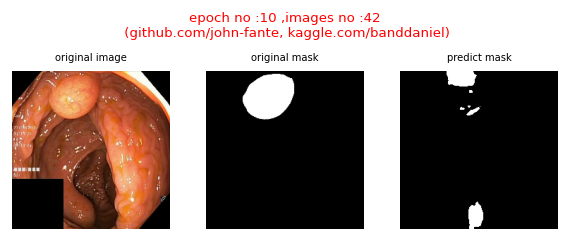

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9212 - dice_coef_loss: 0.0788 - jaccard: 0.8548 - loss: 0.0428
Epoch 11/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8640 - dice_coef_loss: 0.1360 - jaccard: 0.7630 - loss: 0.0716

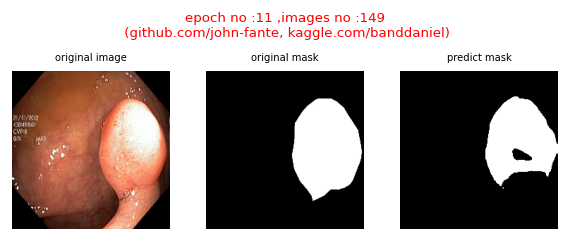

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.8640 - dice_coef_loss: 0.1360 - jaccard: 0.7631 - loss: 0.0716
Epoch 12/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9011 - dice_coef_loss: 0.0989 - jaccard: 0.8225 - loss: 0.0468

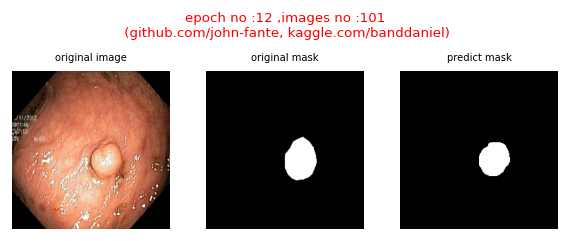

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9012 - dice_coef_loss: 0.0988 - jaccard: 0.8226 - loss: 0.0468
Epoch 13/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8967 - dice_coef_loss: 0.1033 - jaccard: 0.8145 - loss: 0.0561

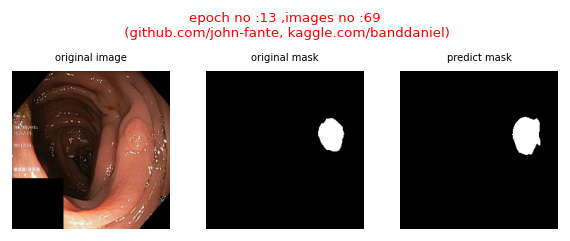

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.8970 - dice_coef_loss: 0.1030 - jaccard: 0.8148 - loss: 0.0560
Epoch 14/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9280 - dice_coef_loss: 0.0720 - jaccard: 0.8665 - loss: 0.0370

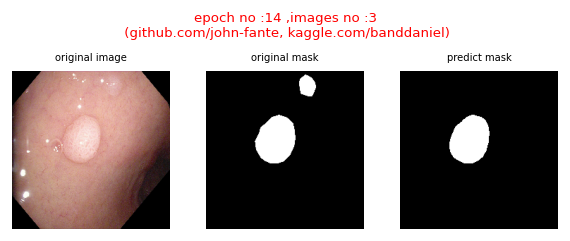

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9281 - dice_coef_loss: 0.0719 - jaccard: 0.8667 - loss: 0.0369
Epoch 15/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9493 - dice_coef_loss: 0.0507 - jaccard: 0.9036 - loss: 0.0259

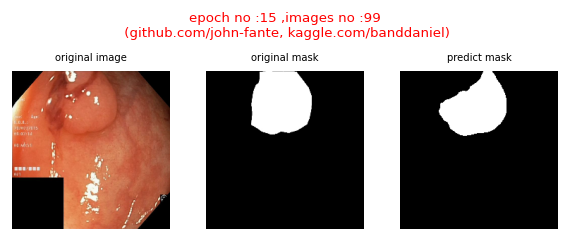

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9493 - dice_coef_loss: 0.0507 - jaccard: 0.9036 - loss: 0.0259
Epoch 16/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9588 - dice_coef_loss: 0.0412 - jaccard: 0.9210 - loss: 0.0208

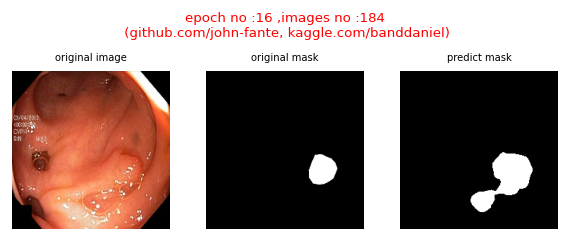

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9588 - dice_coef_loss: 0.0412 - jaccard: 0.9210 - loss: 0.0208
Epoch 17/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9627 - dice_coef_loss: 0.0373 - jaccard: 0.9282 - loss: 0.0190

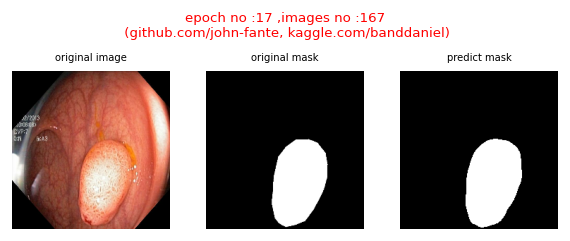

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9627 - dice_coef_loss: 0.0373 - jaccard: 0.9281 - loss: 0.0190
Epoch 18/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9642 - dice_coef_loss: 0.0358 - jaccard: 0.9310 - loss: 0.0182

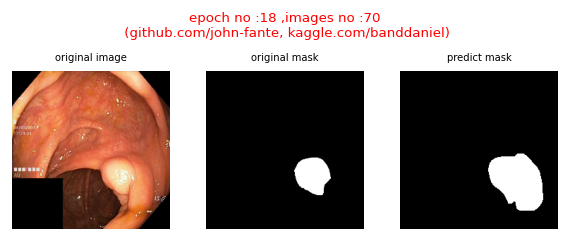

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9642 - dice_coef_loss: 0.0358 - jaccard: 0.9309 - loss: 0.0182
Epoch 19/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9630 - dice_coef_loss: 0.0370 - jaccard: 0.9288 - loss: 0.0179

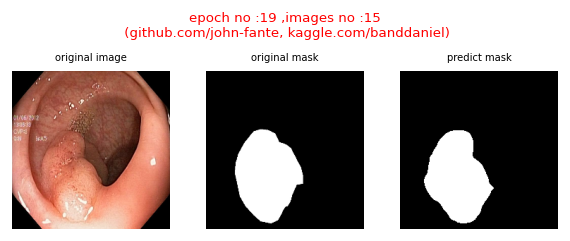

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9630 - dice_coef_loss: 0.0370 - jaccard: 0.9288 - loss: 0.0179
Epoch 20/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9689 - dice_coef_loss: 0.0311 - jaccard: 0.9398 - loss: 0.0168

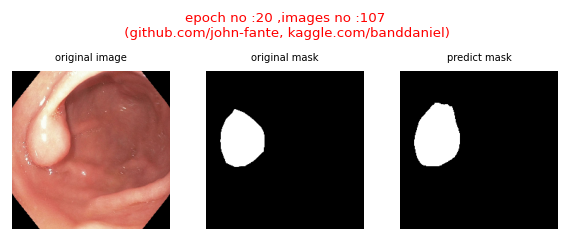

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9689 - dice_coef_loss: 0.0311 - jaccard: 0.9398 - loss: 0.0168
Epoch 21/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9683 - dice_coef_loss: 0.0317 - jaccard: 0.9387 - loss: 0.0150

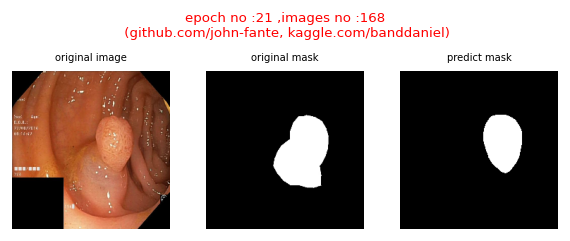

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9684 - dice_coef_loss: 0.0316 - jaccard: 0.9387 - loss: 0.0150
Epoch 22/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9705 - dice_coef_loss: 0.0295 - jaccard: 0.9427 - loss: 0.0149

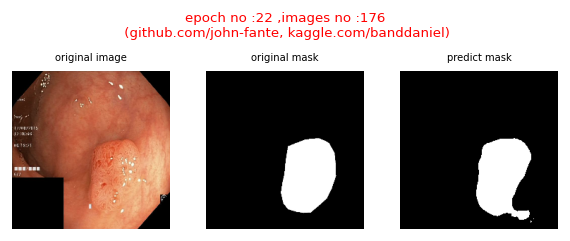

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9705 - dice_coef_loss: 0.0295 - jaccard: 0.9427 - loss: 0.0149
Epoch 23/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9711 - dice_coef_loss: 0.0289 - jaccard: 0.9439 - loss: 0.0136

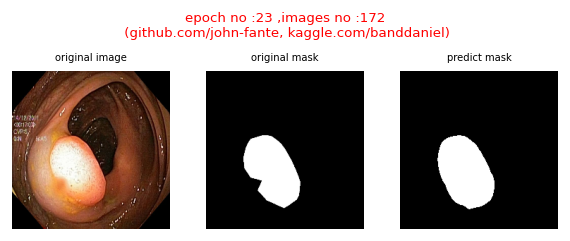

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9711 - dice_coef_loss: 0.0289 - jaccard: 0.9439 - loss: 0.0136
Epoch 24/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9721 - dice_coef_loss: 0.0279 - jaccard: 0.9458 - loss: 0.0139

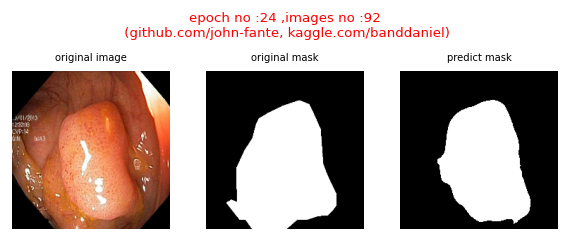

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9721 - dice_coef_loss: 0.0279 - jaccard: 0.9458 - loss: 0.0139
Epoch 25/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9756 - dice_coef_loss: 0.0244 - jaccard: 0.9523 - loss: 0.0126

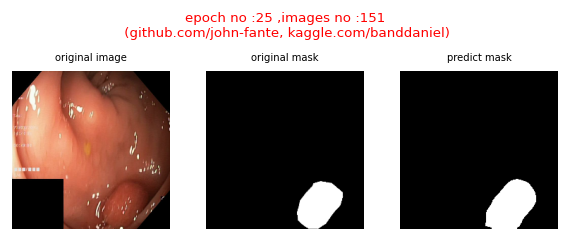

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9755 - dice_coef_loss: 0.0245 - jaccard: 0.9523 - loss: 0.0126
Epoch 26/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9737 - dice_coef_loss: 0.0263 - jaccard: 0.9489 - loss: 0.0124

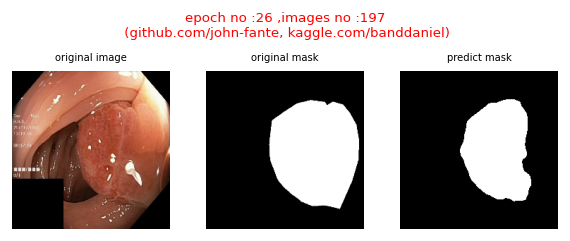

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9738 - dice_coef_loss: 0.0262 - jaccard: 0.9489 - loss: 0.0124
Epoch 27/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9757 - dice_coef_loss: 0.0243 - jaccard: 0.9527 - loss: 0.0122

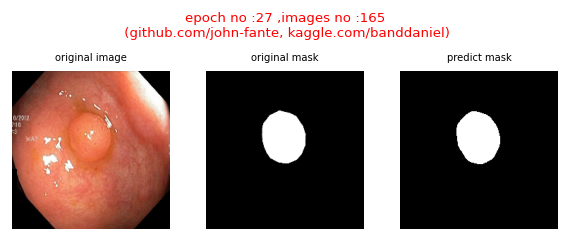

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9757 - dice_coef_loss: 0.0243 - jaccard: 0.9527 - loss: 0.0122
Epoch 28/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9747 - dice_coef_loss: 0.0253 - jaccard: 0.9507 - loss: 0.0123

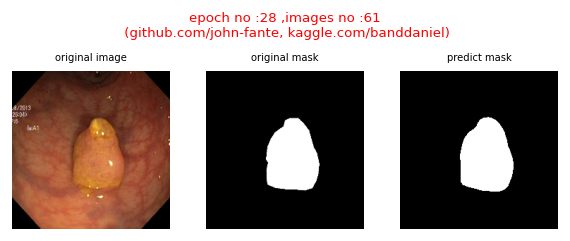

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9747 - dice_coef_loss: 0.0253 - jaccard: 0.9507 - loss: 0.0123
Epoch 29/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9744 - dice_coef_loss: 0.0256 - jaccard: 0.9501 - loss: 0.0125

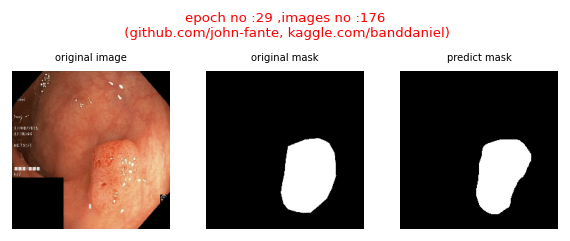

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9744 - dice_coef_loss: 0.0256 - jaccard: 0.9501 - loss: 0.0125
Epoch 30/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9774 - dice_coef_loss: 0.0226 - jaccard: 0.9559 - loss: 0.0115

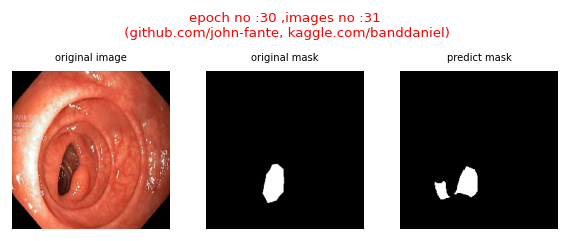

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9774 - dice_coef_loss: 0.0226 - jaccard: 0.9558 - loss: 0.0115
Epoch 31/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9761 - dice_coef_loss: 0.0239 - jaccard: 0.9533 - loss: 0.0119

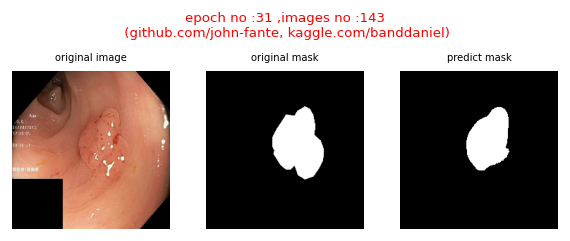

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9761 - dice_coef_loss: 0.0239 - jaccard: 0.9533 - loss: 0.0119
Epoch 32/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9774 - dice_coef_loss: 0.0226 - jaccard: 0.9558 - loss: 0.0115

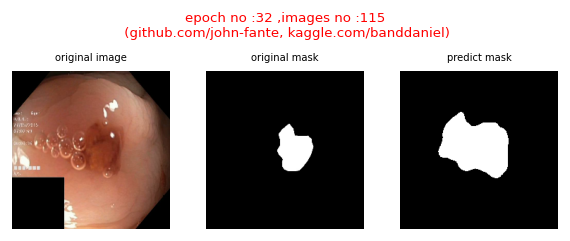

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9773 - dice_coef_loss: 0.0227 - jaccard: 0.9557 - loss: 0.0115
Epoch 33/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9762 - dice_coef_loss: 0.0238 - jaccard: 0.9536 - loss: 0.0121

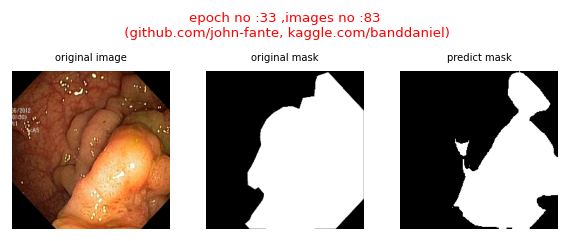

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9762 - dice_coef_loss: 0.0238 - jaccard: 0.9536 - loss: 0.0121
Epoch 34/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9766 - dice_coef_loss: 0.0234 - jaccard: 0.9543 - loss: 0.0118

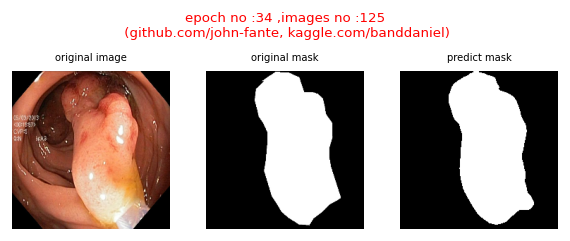

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9766 - dice_coef_loss: 0.0234 - jaccard: 0.9543 - loss: 0.0118
Epoch 35/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9784 - dice_coef_loss: 0.0216 - jaccard: 0.9578 - loss: 0.0111

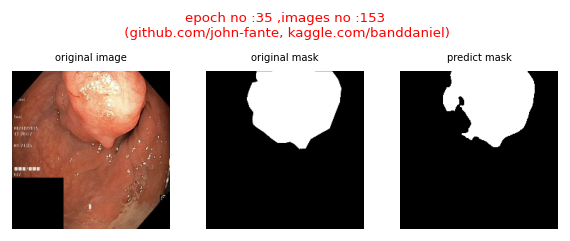

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9784 - dice_coef_loss: 0.0216 - jaccard: 0.9578 - loss: 0.0111
Epoch 36/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9786 - dice_coef_loss: 0.0214 - jaccard: 0.9581 - loss: 0.0104

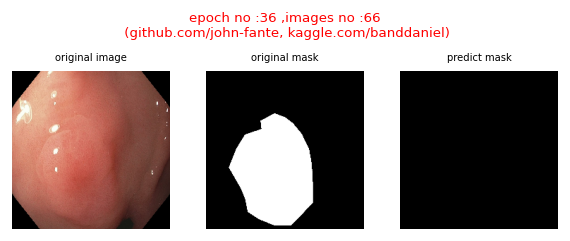

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9786 - dice_coef_loss: 0.0214 - jaccard: 0.9581 - loss: 0.0104
Epoch 37/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9786 - dice_coef_loss: 0.0214 - jaccard: 0.9581 - loss: 0.0103

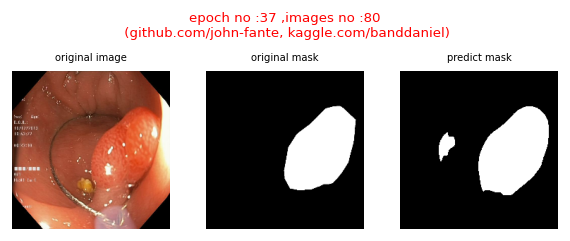

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dice_coef: 0.9786 - dice_coef_loss: 0.0214 - jaccard: 0.9581 - loss: 0.0103
Epoch 38/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9787 - dice_coef_loss: 0.0213 - jaccard: 0.9584 - loss: 0.0104

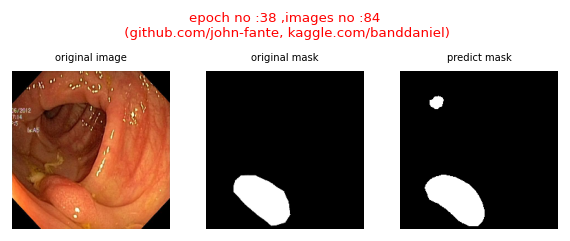

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9787 - dice_coef_loss: 0.0213 - jaccard: 0.9584 - loss: 0.0104
Epoch 39/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9788 - dice_coef_loss: 0.0212 - jaccard: 0.9586 - loss: 0.0104

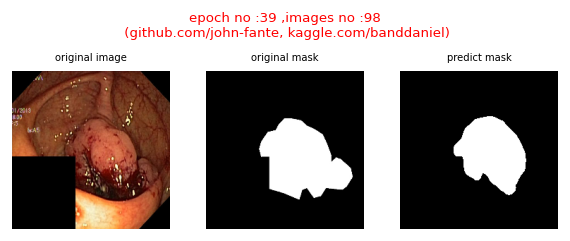

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9789 - dice_coef_loss: 0.0211 - jaccard: 0.9586 - loss: 0.0104
Epoch 40/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.9779 - dice_coef_loss: 0.0221 - jaccard: 0.9571 - loss: 0.0115

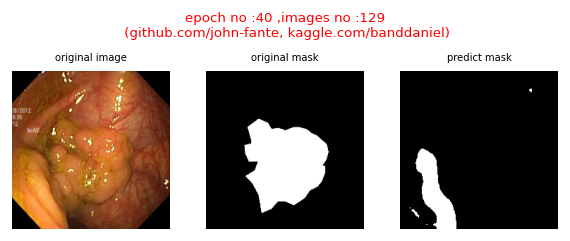

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - dice_coef: 0.9773 - dice_coef_loss: 0.0227 - jaccard: 0.9562 - loss: 0.0119


In [119]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 40,  callbacks = my_callbacks)


Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.7696 - dice_coef_loss: 0.2304 - jaccard: 0.6297 - loss: 0.1234

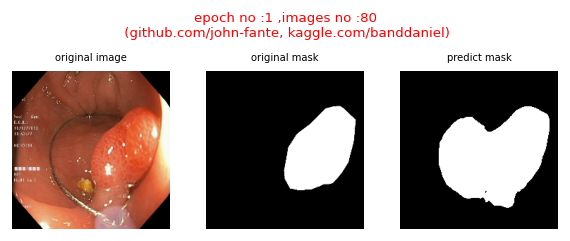

100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - dice_coef: 0.7700 - dice_coef_loss: 0.2300 - jaccard: 0.6302 - loss: 0.1232 - learning_rate: 1.0000e-04
Epoch 2/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9041 - dice_coef_loss: 0.0959 - jaccard: 0.8264 - loss: 0.0481

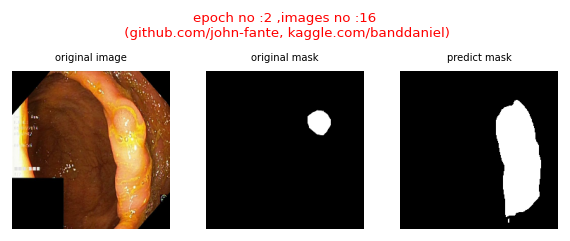

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9043 - dice_coef_loss: 0.0957 - jaccard: 0.8268 - loss: 0.0480 - learning_rate: 1.0000e-04
Epoch 3/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9439 - dice_coef_loss: 0.0561 - jaccard: 0.8940 - loss: 0.0287

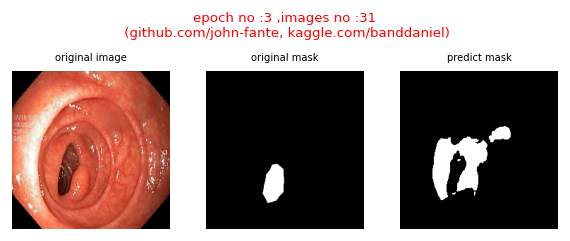

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9440 - dice_coef_loss: 0.0560 - jaccard: 0.8941 - loss: 0.0287 - learning_rate: 1.0000e-04
Epoch 4/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9570 - dice_coef_loss: 0.0430 - jaccard: 0.9179 - loss: 0.0206

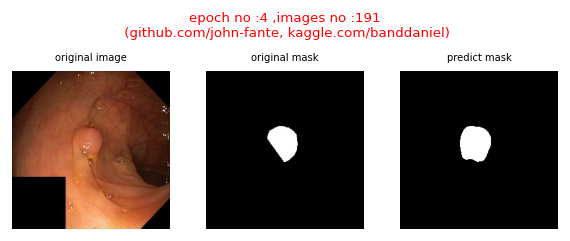

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9571 - dice_coef_loss: 0.0429 - jaccard: 0.9180 - loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 5/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9648 - dice_coef_loss: 0.0352 - jaccard: 0.9321 - loss: 0.0178

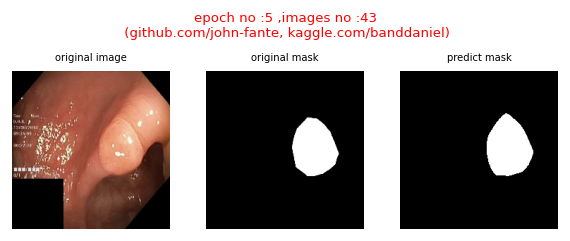

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9648 - dice_coef_loss: 0.0352 - jaccard: 0.9321 - loss: 0.0178 - learning_rate: 1.0000e-04
Epoch 6/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9698 - dice_coef_loss: 0.0302 - jaccard: 0.9415 - loss: 0.0149

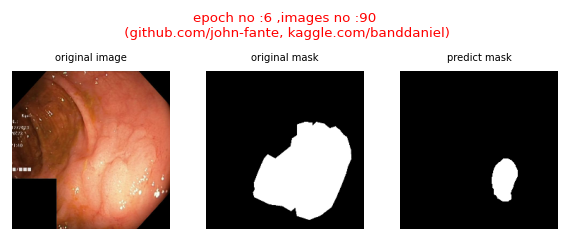

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9698 - dice_coef_loss: 0.0302 - jaccard: 0.9415 - loss: 0.0149 - learning_rate: 1.0000e-04
Epoch 7/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9717 - dice_coef_loss: 0.0283 - jaccard: 0.9451 - loss: 0.0135

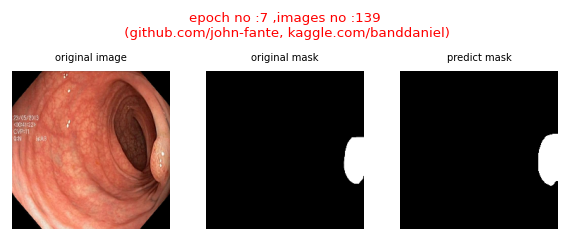

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9717 - dice_coef_loss: 0.0283 - jaccard: 0.9451 - loss: 0.0135 - learning_rate: 1.0000e-04
Epoch 8/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9743 - dice_coef_loss: 0.0257 - jaccard: 0.9499 - loss: 0.0123

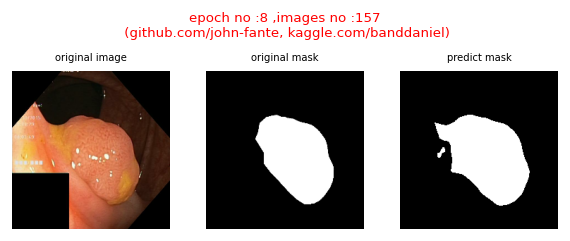

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9743 - dice_coef_loss: 0.0257 - jaccard: 0.9500 - loss: 0.0123 - learning_rate: 1.0000e-04
Epoch 9/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9752 - dice_coef_loss: 0.0248 - jaccard: 0.9517 - loss: 0.0111

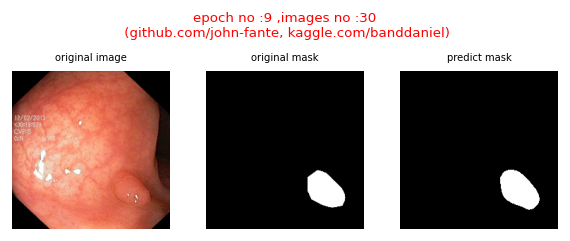

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9752 - dice_coef_loss: 0.0248 - jaccard: 0.9518 - loss: 0.0111 - learning_rate: 1.0000e-04
Epoch 10/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9778 - dice_coef_loss: 0.0222 - jaccard: 0.9567 - loss: 0.0109

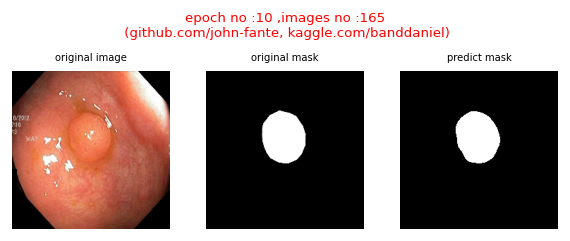

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9778 - dice_coef_loss: 0.0222 - jaccard: 0.9567 - loss: 0.0109 - learning_rate: 1.0000e-04
Epoch 11/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9784 - dice_coef_loss: 0.0216 - jaccard: 0.9578 - loss: 0.0101

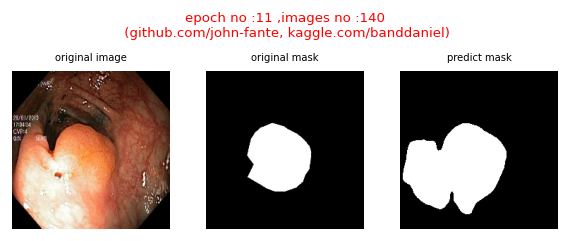

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9784 - dice_coef_loss: 0.0216 - jaccard: 0.9578 - loss: 0.0101 - learning_rate: 1.0000e-04
Epoch 12/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9792 - dice_coef_loss: 0.0208 - jaccard: 0.9593 - loss: 0.0095

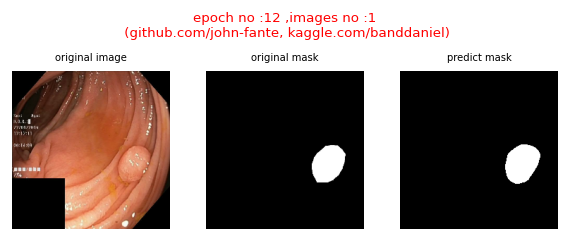

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9792 - dice_coef_loss: 0.0208 - jaccard: 0.9593 - loss: 0.0095 - learning_rate: 1.0000e-04
Epoch 13/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9813 - dice_coef_loss: 0.0187 - jaccard: 0.9632 - loss: 0.0093

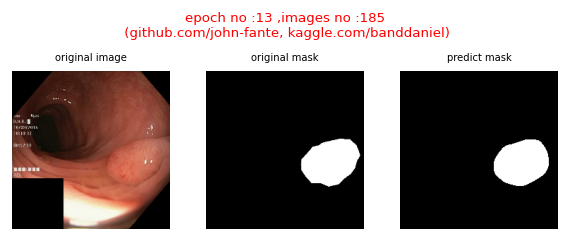

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - dice_coef: 0.9813 - dice_coef_loss: 0.0187 - jaccard: 0.9632 - loss: 0.0093 - learning_rate: 1.0000e-04
Epoch 14/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9820 - dice_coef_loss: 0.0180 - jaccard: 0.9647 - loss: 0.0087

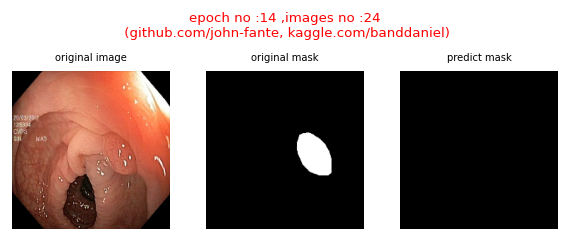

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9820 - dice_coef_loss: 0.0180 - jaccard: 0.9647 - loss: 0.0087 - learning_rate: 1.0000e-04
Epoch 15/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9821 - dice_coef_loss: 0.0179 - jaccard: 0.9649 - loss: 0.0085

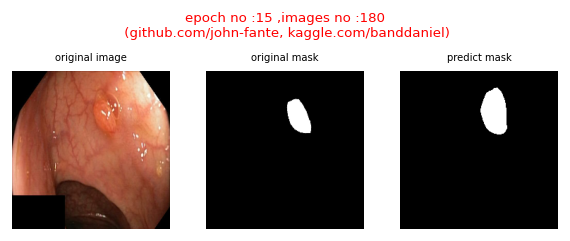

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9821 - dice_coef_loss: 0.0179 - jaccard: 0.9649 - loss: 0.0085 - learning_rate: 1.0000e-04
Epoch 16/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9825 - dice_coef_loss: 0.0175 - jaccard: 0.9656 - loss: 0.0085

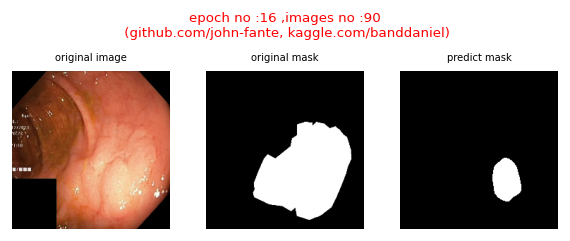

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9825 - dice_coef_loss: 0.0175 - jaccard: 0.9657 - loss: 0.0085 - learning_rate: 1.0000e-04
Epoch 17/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9837 - dice_coef_loss: 0.0163 - jaccard: 0.9680 - loss: 0.0082

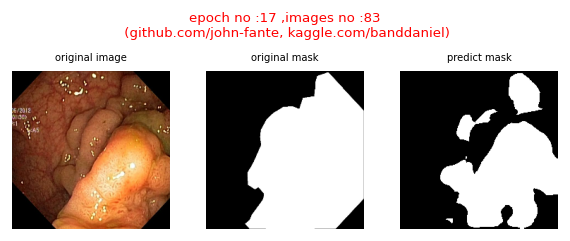

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9837 - dice_coef_loss: 0.0163 - jaccard: 0.9680 - loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 18/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9850 - dice_coef_loss: 0.0150 - jaccard: 0.9704 - loss: 0.0078

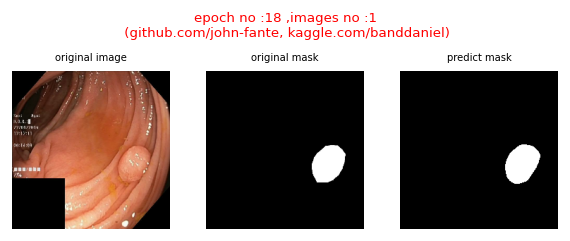

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9850 - dice_coef_loss: 0.0150 - jaccard: 0.9704 - loss: 0.0078 - learning_rate: 1.0000e-04
Epoch 19/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9841 - dice_coef_loss: 0.0159 - jaccard: 0.9686 - loss: 0.0074

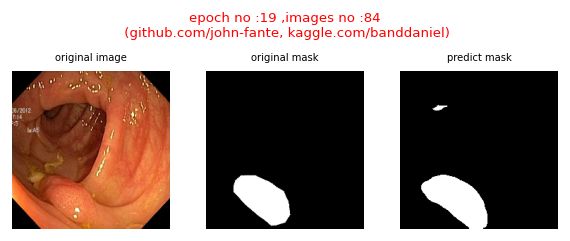

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9841 - dice_coef_loss: 0.0159 - jaccard: 0.9686 - loss: 0.0074 - learning_rate: 1.0000e-04
Epoch 20/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9848 - dice_coef_loss: 0.0152 - jaccard: 0.9701 - loss: 0.0071

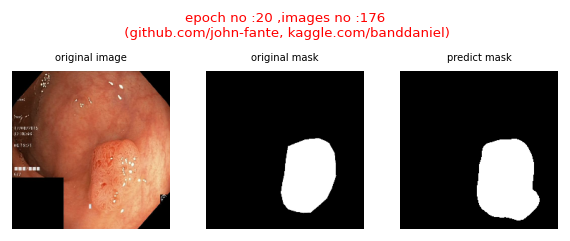

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9848 - dice_coef_loss: 0.0152 - jaccard: 0.9701 - loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 21/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9849 - dice_coef_loss: 0.0151 - jaccard: 0.9702 - loss: 0.0075

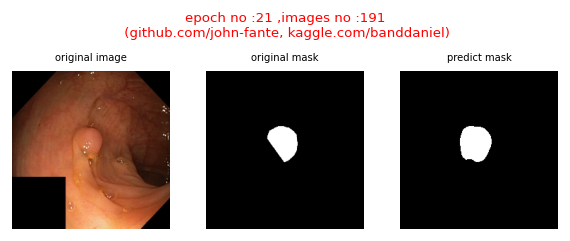

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9849 - dice_coef_loss: 0.0151 - jaccard: 0.9702 - loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 22/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9841 - dice_coef_loss: 0.0159 - jaccard: 0.9687 - loss: 0.0075

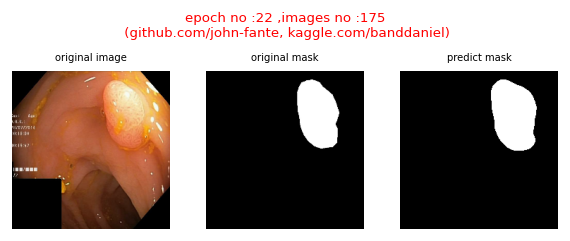

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9841 - dice_coef_loss: 0.0159 - jaccard: 0.9687 - loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 23/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9855 - dice_coef_loss: 0.0145 - jaccard: 0.9714 - loss: 0.0071

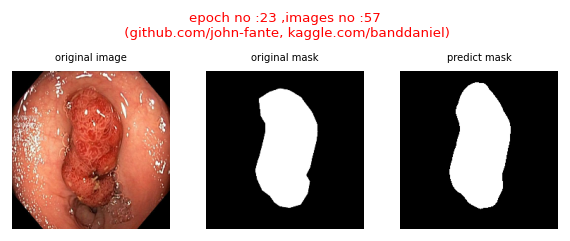

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9855 - dice_coef_loss: 0.0145 - jaccard: 0.9714 - loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 24/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9849 - dice_coef_loss: 0.0151 - jaccard: 0.9703 - loss: 0.0071

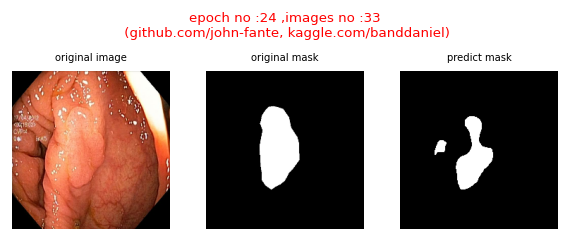

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9849 - dice_coef_loss: 0.0151 - jaccard: 0.9703 - loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 25/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9855 - dice_coef_loss: 0.0145 - jaccard: 0.9714 - loss: 0.0068

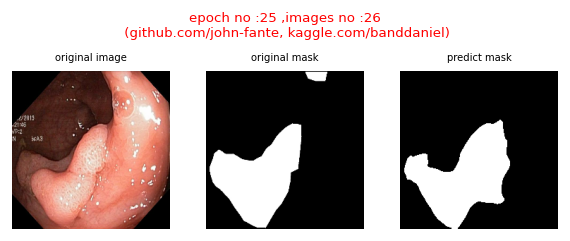

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9855 - dice_coef_loss: 0.0145 - jaccard: 0.9714 - loss: 0.0068 - learning_rate: 1.0000e-04
Epoch 26/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9862 - dice_coef_loss: 0.0138 - jaccard: 0.9728 - loss: 0.0066

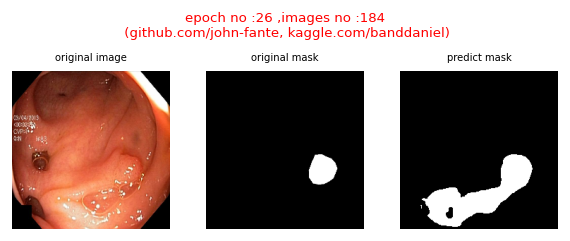

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9862 - dice_coef_loss: 0.0138 - jaccard: 0.9728 - loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 27/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9864 - dice_coef_loss: 0.0136 - jaccard: 0.9732 - loss: 0.0065

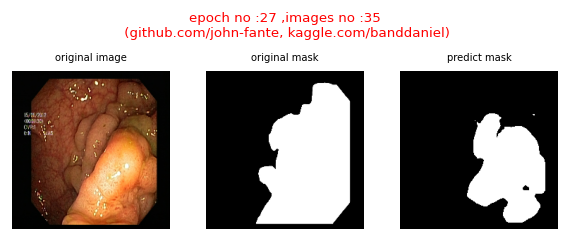

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9864 - dice_coef_loss: 0.0136 - jaccard: 0.9732 - loss: 0.0065 - learning_rate: 1.0000e-04
Epoch 28/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9861 - dice_coef_loss: 0.0139 - jaccard: 0.9726 - loss: 0.0065

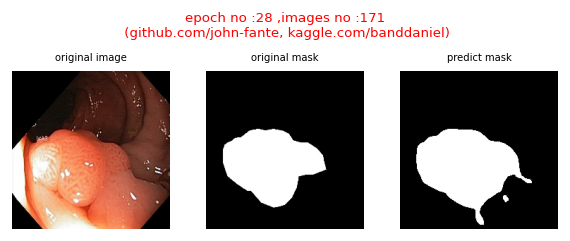

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9861 - dice_coef_loss: 0.0139 - jaccard: 0.9726 - loss: 0.0065 - learning_rate: 1.0000e-04
Epoch 29/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9862 - dice_coef_loss: 0.0138 - jaccard: 0.9728 - loss: 0.0064

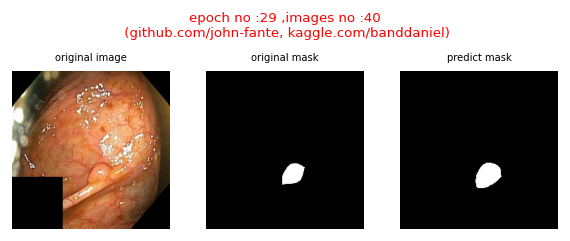

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9862 - dice_coef_loss: 0.0138 - jaccard: 0.9728 - loss: 0.0064 - learning_rate: 1.0000e-04
Epoch 30/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9867 - dice_coef_loss: 0.0133 - jaccard: 0.9738 - loss: 0.0066

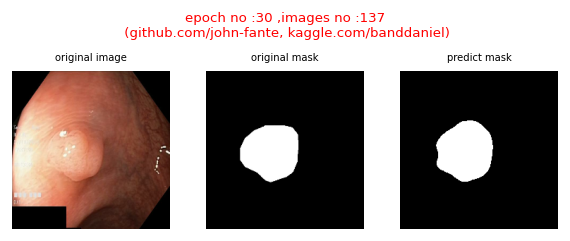

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9867 - dice_coef_loss: 0.0133 - jaccard: 0.9738 - loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 31/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9870 - dice_coef_loss: 0.0130 - jaccard: 0.9743 - loss: 0.0067

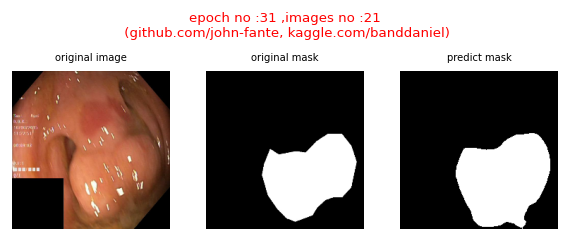

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9870 - dice_coef_loss: 0.0130 - jaccard: 0.9743 - loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 32/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9870 - dice_coef_loss: 0.0130 - jaccard: 0.9744 - loss: 0.0066

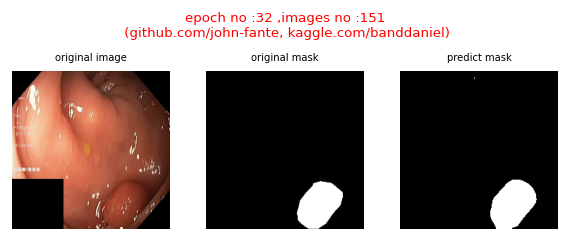

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9870 - dice_coef_loss: 0.0130 - jaccard: 0.9744 - loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 33/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9872 - dice_coef_loss: 0.0128 - jaccard: 0.9747 - loss: 0.0061

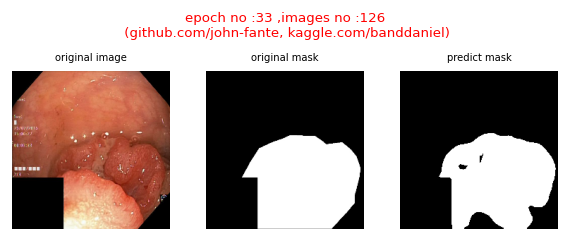

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9872 - dice_coef_loss: 0.0128 - jaccard: 0.9747 - loss: 0.0061 - learning_rate: 1.0000e-04
Epoch 34/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9874 - dice_coef_loss: 0.0126 - jaccard: 0.9750 - loss: 0.0062

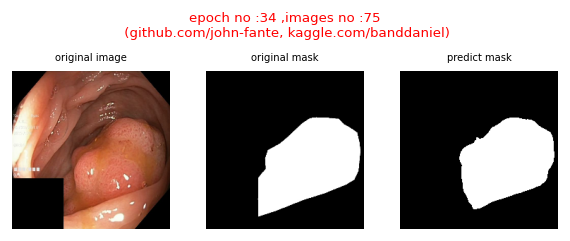

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9874 - dice_coef_loss: 0.0126 - jaccard: 0.9750 - loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 35/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9866 - dice_coef_loss: 0.0134 - jaccard: 0.9736 - loss: 0.0065

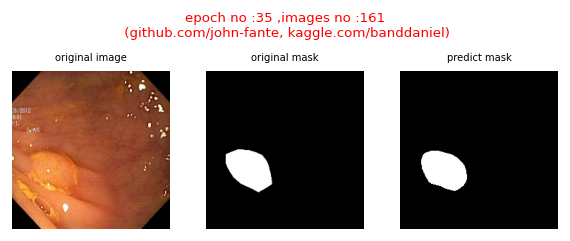

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9866 - dice_coef_loss: 0.0134 - jaccard: 0.9736 - loss: 0.0065 - learning_rate: 1.0000e-04
Epoch 36/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9875 - dice_coef_loss: 0.0125 - jaccard: 0.9753 - loss: 0.0062

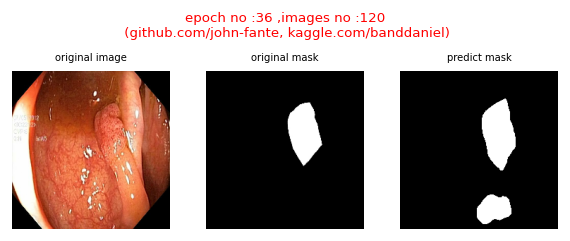

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.9875 - dice_coef_loss: 0.0125 - jaccard: 0.9753 - loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 37/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9876 - dice_coef_loss: 0.0124 - jaccard: 0.9755 - loss: 0.0059

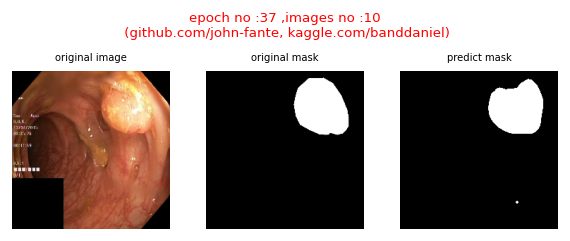

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9876 - dice_coef_loss: 0.0124 - jaccard: 0.9755 - loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 38/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9876 - dice_coef_loss: 0.0124 - jaccard: 0.9756 - loss: 0.0059

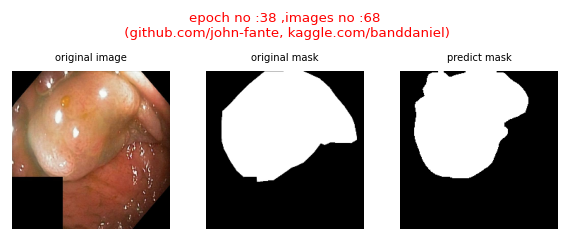

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9876 - dice_coef_loss: 0.0124 - jaccard: 0.9756 - loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 39/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9877 - dice_coef_loss: 0.0123 - jaccard: 0.9758 - loss: 0.0059

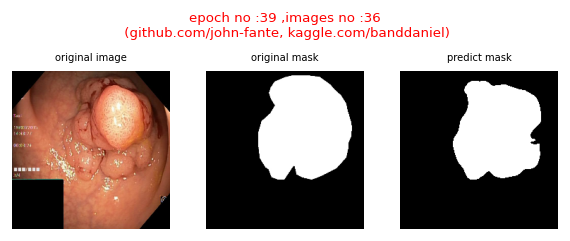

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9877 - dice_coef_loss: 0.0123 - jaccard: 0.9758 - loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 40/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9878 - dice_coef_loss: 0.0122 - jaccard: 0.9759 - loss: 0.0063

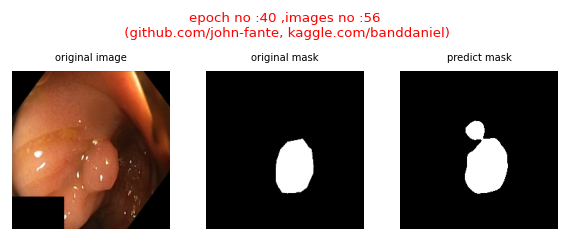

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.9878 - dice_coef_loss: 0.0122 - jaccard: 0.9759 - loss: 0.0063 - learning_rate: 1.0000e-04


In [132]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ✅ Use a lower learning rate + gradient clipping
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)

# ✅ Compile with custom metrics
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[dice_coef_loss, dice_coef, jaccard]
)

# ✅ Define callbacks
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",            # Save model file
    monitor='val_dice_coef',    # Monitor the Dice score
    save_best_only=True,        # Save only the best
    mode='max',
    verbose=1
)

early_stop_cb = EarlyStopping(
    monitor='val_dice_coef',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

lr_scheduler_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# ✅ Fit the model
history = model.fit(
    train_dataset,

    epochs=40,
    callbacks=[checkpoint_cb, early_stop_cb, lr_scheduler_cb, PredictDuringTraining()]
)


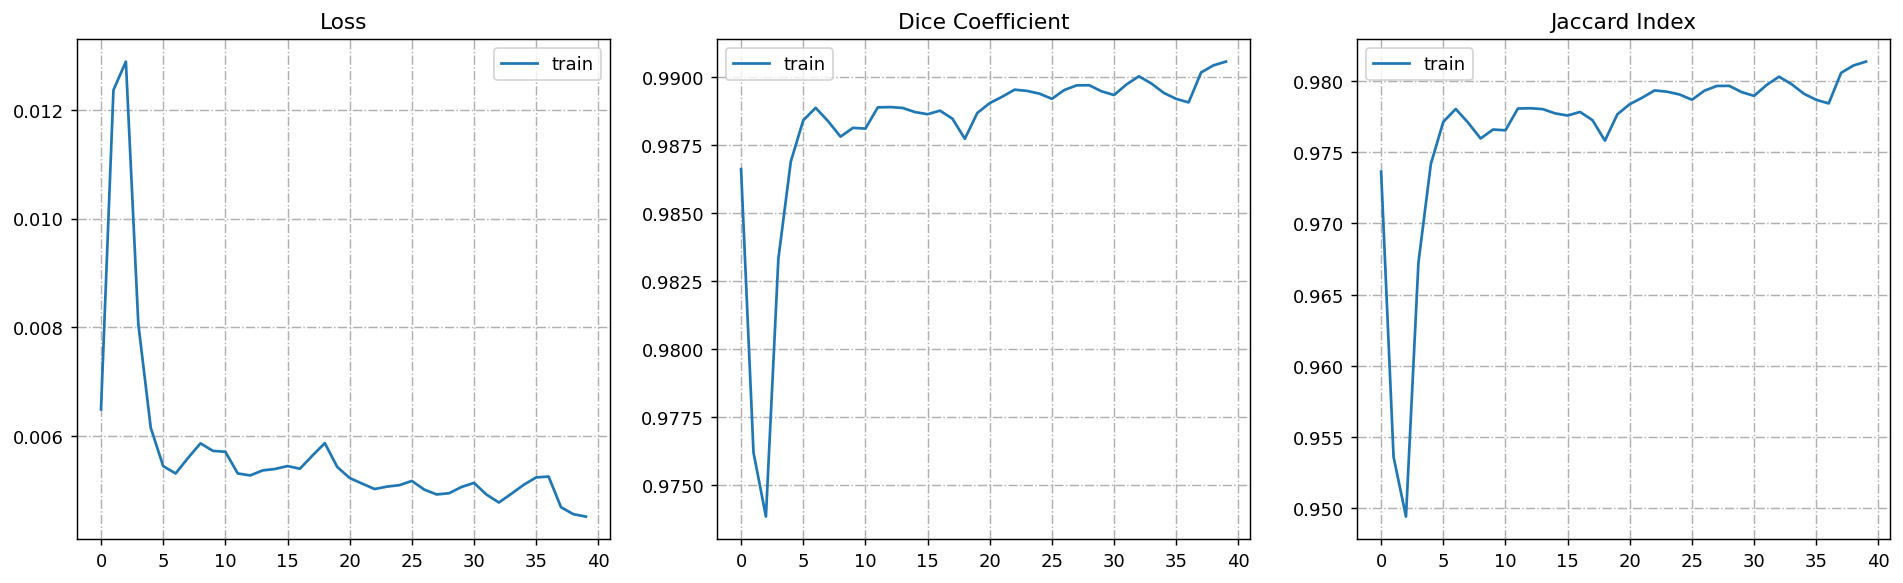

In [120]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(history.history['loss'])
axs[0].legend(["train"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(history.history['dice_coef'])
axs[1].legend(["train"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(history.history['jaccard'])
axs[2].legend(["train"])


In [133]:

test_eval = model.evaluate(test_dataset)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - dice_coef: 0.8370 - dice_coef_loss: 0.1630 - jaccard: 0.7249 - loss: 0.4163


In [134]:
def evaluate_test_dataset_with_threshold(model, test_dataset, threshold=0.3):
    all_preds = []
    all_masks = []

    for batch in test_dataset:
        images, masks = batch
        preds = model.predict(images, verbose=0)
        preds = (preds > threshold).astype(np.float32)  # Cast to float32
        masks = masks.numpy().astype(np.float32)        # Cast to float32

        all_preds.append(preds)
        all_masks.append(masks)

    # Concatenate all batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)

    # Flatten for metric calculation
    y_true_f = K.flatten(all_masks)
    y_pred_f = K.flatten(all_preds)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    jaccard = intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6)

    dice = dice.numpy()
    jaccard = jaccard.numpy()

    print(f"Thresholded Dice Coefficient: {dice:.4f}")
    print(f"Thresholded Jaccard Index: {jaccard:.4f}")

    return dice, jaccard
evaluate_test_dataset_with_threshold(model, test_dataset, threshold=0.3)


Thresholded Dice Coefficient: 0.8600
Thresholded Jaccard Index: 0.7545


(np.float32(0.8600422), np.float32(0.75445086))

In [135]:
test_take1 = test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

pred_ = np.squeeze(pred)

threshold_1  = 0.3 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.99 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


In [136]:
def evaluate_model_tf(model, test_dataset):
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy().flatten())
        y_pred.extend(predictions.flatten())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Convert probabilities to binary labels
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Now use the classification metrics
    results = {
        "accuracy": accuracy_score(y_true, y_pred_labels),
        "precision": precision_score(y_true, y_pred_labels),
        "recall": recall_score(y_true, y_pred_labels),
        "f1_score": f1_score(y_true, y_pred_labels),
    }

    return results


In [137]:
# A function that calculating dice and jaccard metrics for prediction
def calc_dice_jaccard_for_prediction(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, tf.uint16)
    y_pred_f = tf.cast(y_pred_f, tf.uint16)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

    return dice.numpy(),jaccard.numpy()


# A function that creating 3 random images in the test set and prediction it
def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs


    fig, axs = plt.subplots(3,4, figsize = (10, 10 ) ,dpi = 150)

    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]

        dice1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[0]
        jac1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[1]

        dice2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[0]
        jac2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[1]


        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 6)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 6)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.3 threshold)'
                            + '\n Dice Coef: {0:0.3f}'.format(dice1)
                            + '\n Jaccard Coef: {0:0.3f}'.format(jac1), color = 'red', fontsize = 6)

        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.99 threshold)' + '\n Dice Coef: {0:0.3f}'.format(dice2) + '\n Jaccard Coef: {0:0.3f}'.format(jac2), color = 'red', fontsize = 6)

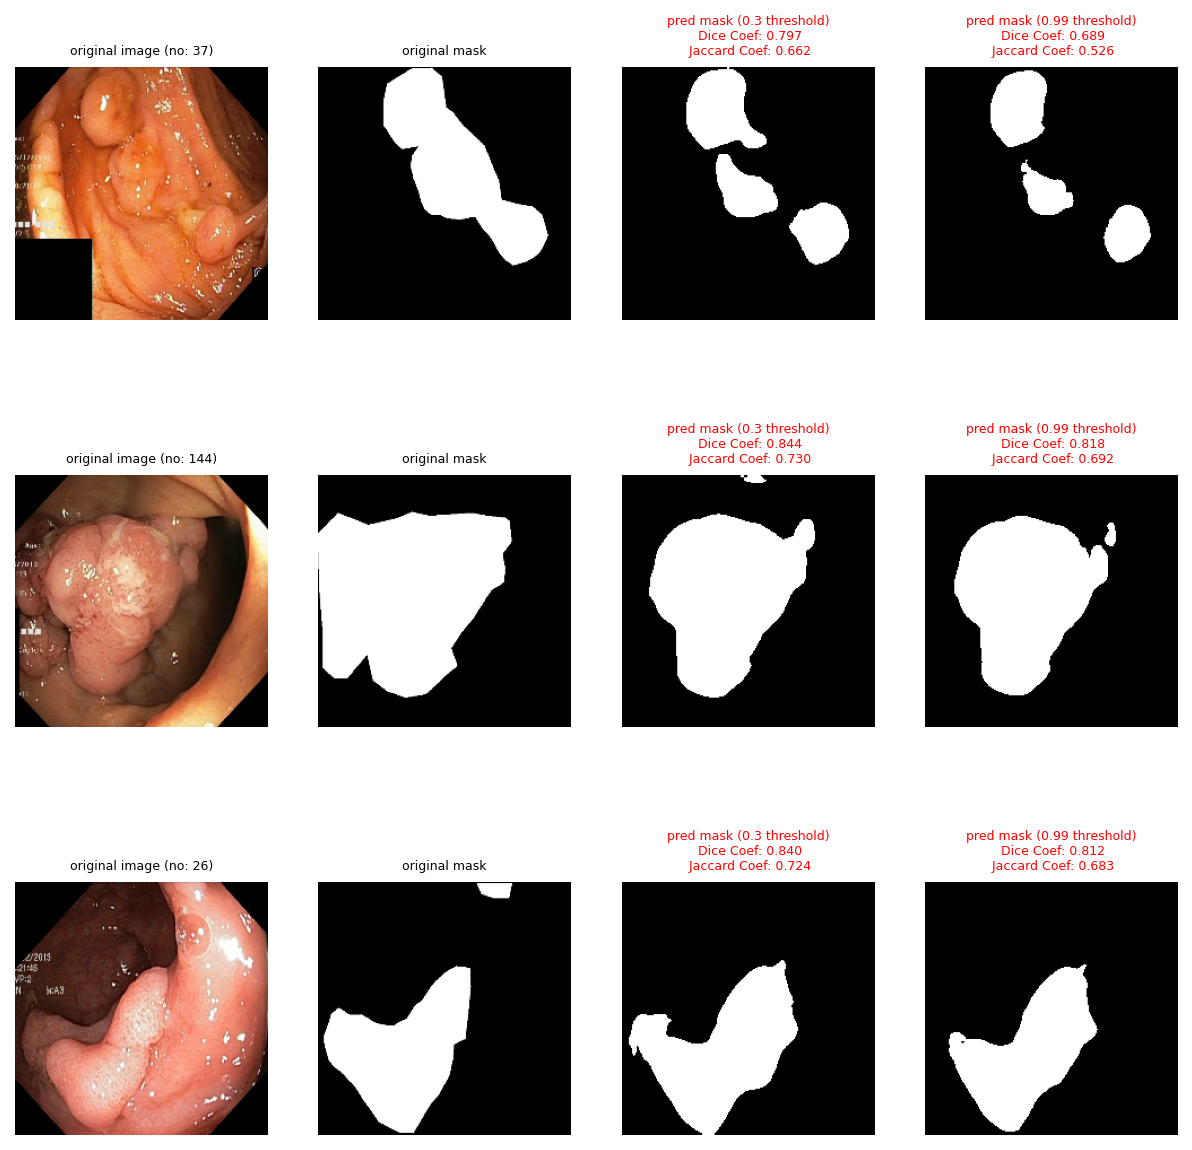

In [138]:
random_test_sample_with_prediction()

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_metrics_with_confusion(model, test_dataset):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy().flatten())
        y_pred.extend(preds.flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Binarize
    y_true_bin = (y_true > 0.5).astype(int)
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Polyp"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # TP, FP, FN
    TP = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
    TN = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
    FP = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
    FN = np.sum((y_true_bin == 1) & (y_pred_bin == 0))

    recall = TP / (TP + FN + 1e-6)
    precision = TP / (TP + FP + 1e-6)
    dice = 2 * TP / (2 * TP + FP + FN + 1e-6)
    iou = TP / (TP + FP + FN + 1e-6)
    fpe = FP / (TP + FP + 1e-6)
    fne = FN / (TP + FN + 1e-6)

    return {
        "IoU": round(iou, 5),
        "Dice": round(dice, 5),
        "Recall": round(recall, 5),
        "Precision": round(precision, 5),
        "FPE": round(fpe, 5),
        "FNE": round(fne, 5),
        "Confusion Matrix": cm.tolist()  # optional if you want to log it
    }


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


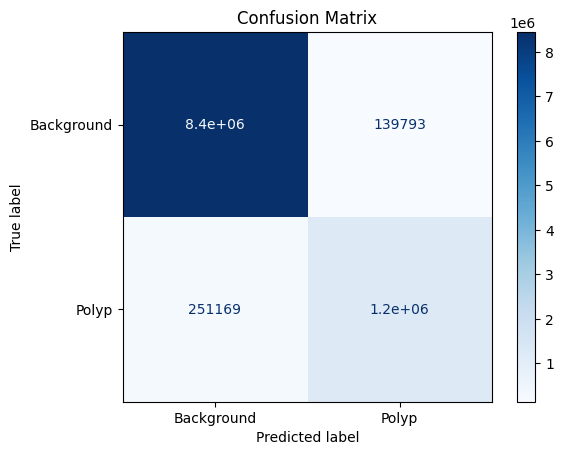

IoU: 0.75442
Dice: 0.86002
Recall: 0.82704
Precision: 0.89574
FPE: 0.10426
FNE: 0.17296


In [142]:
results = compute_metrics_with_confusion(model, test_dataset)

# Print metrics
for k, v in results.items():
    if k != "Confusion Matrix":
        print(f"{k}: {v}")
